In [1]:
import polars as pl 
import polars.selectors as cs
import seaborn as sns
import utils
import get_data
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.manifold import TSNE

In [2]:
frame = pl.read_parquet(r"C:\Users\faune\Downloads\0000.parquet")

In [3]:
frame.drop('idx').with_columns(pl.col('label').replace({0:'negative', 1: 'positive'}))

sentence,label
str,str
"""hide new secre…","""negative"""
"""contains no wi…","""negative"""
"""that loves its…","""positive"""
"""remains utterl…","""negative"""
"""on the worst r…","""negative"""
…,…
"""a delightful c…","""positive"""
"""anguish , ange…","""negative"""
"""at achieving t…","""positive"""


<Axes: xlabel='label', ylabel='Count'>

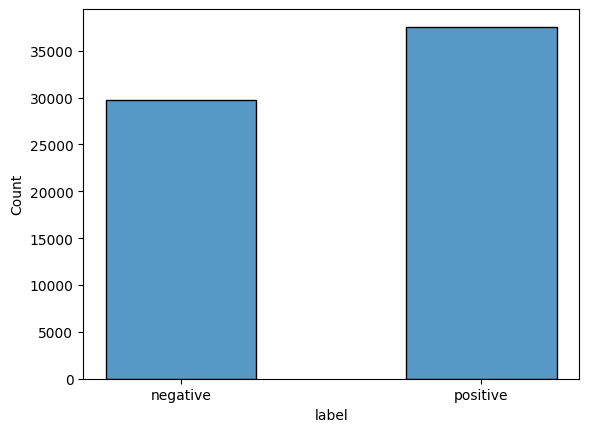

In [4]:
sns.histplot(data = frame.drop('idx').with_columns(pl.col('label').replace({0:'negative', 1: 'positive'})), x='label', shrink=.5) #.pivot(values='sentence', index='idx', columns='label').drop('idx').describe()

In [7]:
frame.with_columns(pl.col('label').replace({0:'negative', 1: 'positive'})).pivot(values='sentence', index='idx', columns='label').drop('idx').describe()

statistic,negative,positive
str,str,str
"""count""","""29780""","""37569"""
"""null_count""","""37569""","""29780"""
"""mean""",null,null
"""std""",null,null
"""min""","""$ 99 bargain-b…","""$ 1.8 million …"
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""zzzzzzzzz ""","""zoom ! """


<Axes: xlabel='nb_of_words', ylabel='Count'>

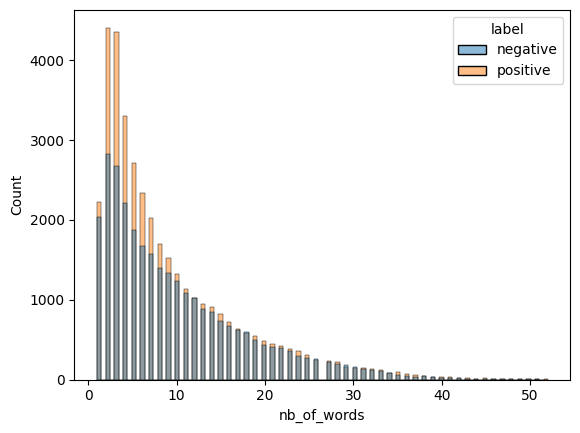

In [11]:
sns.histplot(
    data = (frame
    .with_columns(pl.col('label').replace({0:'negative', 1: 'positive'}))
    .with_columns(pl.col('sentence').str.strip_chars().str.split(' ').list.len().alias('nb_of_words'))),
    x = 'nb_of_words',
    hue='label'
)

In [12]:
similar_sentences = (
    frame
    .drop('idx')
    .with_columns(pl.col('label').replace({0:'negative', 1: 'positive'}))
    .sort('label', descending=True)
    .unstack(step=37569, how="vertical", columns='sentence')
    .rename({'sentence_0': 'positive', 'sentence_1':'negative'})
    .with_columns(pl.col('*').str.strip().str.split(' '))
    .with_columns(pl.col('positive').list.set_intersection('negative').alias('similar_words'))
    .with_columns(pl.col('similar_words').list.len().alias('nb_similar_words'))
    .with_columns(pl.col('positive').list.len().alias('nb_positive_words'))
    .with_columns(pl.col('negative').list.len().alias('nb_negative_words'))
    .sort(['nb_positive_words', 'nb_negative_words'])
    .with_columns(pl.col('nb_similar_words').truediv(pl.col('nb_positive_words')).alias('ratio_positive'))
    .with_columns(pl.col('nb_similar_words').truediv(pl.col('nb_negative_words')).alias('ratio_negative'))
    .with_columns(pl.mean_horizontal(pl.col('ratio_positive'), pl.col('ratio_negative')).alias('ratio_mean'))
    .with_columns(pl.col('ratio_positive').sub(pl.col('ratio_negative')).abs().alias('ratio_diff'))
    .sort(pl.col('similar_words').list.len(), descending=True)
    # .with_columns(pl.col('nb_similar_words').replace({0: None, 1: None}))
    # .drop_nulls(subset='nb_similar_words')
    .sort('ratio_mean', descending=True)
    .sort('ratio_diff')
    .with_columns(pl.col('positive').list.join(' '))
    .with_columns(pl.col('negative').list.join(' '))
    # .filter(pl.col('ratio_mean').ge(0.5), pl.col('ratio_diff').le(0.5), pl.col('nb_positive_words').gt(1), pl.col('nb_negative_words').gt(1))
)

C:\Users\faune\AppData\Local\Temp\ipykernel_33596\1801450877.py:8: DeprecationWarning: `strip` is deprecated. It has been renamed to `strip_chars`.
  .with_columns(pl.col('*').str.strip().str.split(' '))


In [13]:
similar_sentences= similar_sentences.filter(pl.col('nb_similar_words').gt(1))

In [14]:
similar_sentences = similar_sentences.with_columns(
            pl.Series(
                name= 'positive_embeddings', 
                values= get_data._get_embeddings_by_chunks(similar_sentences.select('positive').to_series().to_list(), 50)
            )
        ).with_columns(
            pl.Series(
                name= 'negative_embeddings', 
                values= get_data._get_embeddings_by_chunks(similar_sentences.select('negative').to_series().to_list(), 50)
            )
        )

In [15]:
similar_sentences = (
    similar_sentences
    .with_columns(
        similar_sentences.with_columns(pl.col('positive_embeddings').list.to_array(1024),pl.col('negative_embeddings').list.to_array(1024))
        .map_rows(function=lambda t : tuple(cosine_similarity(X=np.array(t[10]).reshape(1, -1), Y=np.array(t[11]).reshape(1, -1)).tolist()))
    )
    .explode('column_0')
    .sort('column_0')
    .rename({'column_0': 'cosine_similarity'})
    .with_columns(
        similar_sentences.with_columns(pl.col('positive_embeddings').list.to_array(1024),pl.col('negative_embeddings').list.to_array(1024))
        .map_rows(function=lambda t :np.dot(a=t[10], b=np.transpose(t[11])))
    )
    .rename({'map': 'dot_product'})
    .sort('cosine_similarity')
    # .sort(['dot_product', 'cosine_similarity'])
)

In [16]:
similar_sentences.select(cs.by_dtype(pl.Float64)).describe()

statistic,ratio_positive,ratio_negative,ratio_mean,ratio_diff,cosine_similarity,dot_product
str,f64,f64,f64,f64,f64,f64
"""count""",3669.0,3669.0,3669.0,3669.0,3669.0,3669.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.187724,0.181378,0.184551,0.119082,0.654344,0.654343
"""std""",0.106112,0.100314,0.064949,0.107833,0.076659,0.076655
"""min""",0.040816,0.039216,0.063462,0.0,0.290701,0.290625
"""25%""",0.111111,0.111111,0.138235,0.041667,0.601539,0.601494
"""50%""",0.166667,0.157895,0.17378,0.088889,0.662866,0.662838
"""75%""",0.235294,0.222222,0.218391,0.163043,0.715282,0.715389
"""max""",1.0,0.75,0.6,0.909091,0.826643,0.827049


In [17]:
similar_sentences.head(1)

positive,negative,similar_words,nb_similar_words,nb_positive_words,nb_negative_words,ratio_positive,ratio_negative,ratio_mean,ratio_diff,positive_embeddings,negative_embeddings,cosine_similarity,dot_product
str,str,list[str],u32,u32,u32,f64,f64,f64,f64,list[f64],list[f64],f64,f64
"""been given the…","""whose portrait…","[""of"", ""a""]",2,7,6,0.285714,0.333333,0.309524,0.047619,"[-0.064453, 0.009811, … 0.000371]","[-0.022507, 0.034973, … -0.049072]",0.290701,0.487754


In [18]:
tsne = TSNE(n_components=2, random_state=0)
tsne = tsne.fit_transform(np.array(similar_sentences['positive_embeddings'].to_list()))

In [19]:
similar_sentences = similar_sentences.with_columns(pl.Series(name = 'positive_tsne', values = tsne))

In [20]:
tsne = TSNE(n_components=2, random_state=0)
tsne = tsne.fit_transform(np.array(similar_sentences['negative_embeddings'].to_list()))
similar_sentences = similar_sentences.with_columns(pl.Series(name = 'negative_tsne', values = tsne))

In [21]:
similar_sentences = similar_sentences.with_columns(
        similar_sentences
        .map_rows(function=lambda t : tuple(cosine_similarity(X=np.array(t[14]).reshape(1, -1), Y=np.array(t[15]).reshape(1, -1)).tolist()))
    ).rename({'column_0':'cosine_similarity_tsne'})

In [22]:
similar_sentences = similar_sentences.with_columns(
        similar_sentences.with_columns(pl.col('positive_embeddings').list.to_array(1024),pl.col('negative_embeddings').list.to_array(1024))
        .map_rows(function=lambda t :np.dot(a=t[10], b=np.transpose(t[11])))
    ).explode('cosine_similarity_tsne').sort('cosine_similarity_tsne').rename({'map':'dot_product_tsne'})


In [23]:
similar_sentences.filter(pl.col('ratio_mean').ge(0.3))

positive,negative,similar_words,nb_similar_words,nb_positive_words,nb_negative_words,ratio_positive,ratio_negative,ratio_mean,ratio_diff,positive_embeddings,negative_embeddings,cosine_similarity,dot_product,positive_tsne,negative_tsne,cosine_similarity_tsne,dot_product_tsne
str,str,list[str],u32,u32,u32,f64,f64,f64,f64,list[f64],list[f64],f64,f64,list[f32],list[f32],f64,f64
"""comes along ev…",""", a movie come…","[""comes"", ""along""]",2,4,19,0.5,0.105263,0.302632,0.394737,"[-0.05835, 0.020416, … -0.026718]","[-0.025986, 0.035706, … -0.01432]",0.699435,0.639692,"[20.111223, -42.441784]","[-13.082291, 30.125917]",-0.999461,0.699593
"""she is a lione…","""there is nothi…","[""is"", ""a""]",2,4,9,0.5,0.222222,0.361111,0.277778,"[-0.014496, 0.051514, … -0.021851]","[0.006077, 0.031219, … -0.02684]",0.509608,0.682925,"[13.702863, -20.928885]","[-44.012165, 62.106968]",-0.999323,0.509513
"""the courage of…","""its body humor…","[""of"", ""its"", ""and""]",3,11,7,0.272727,0.428571,0.350649,0.155844,"[-0.040039, 0.006851, … 0.002014]","[-0.03595, -0.022583, … -0.0075]",0.649992,0.753794,"[0.549366, 39.81934]","[1.49533, -54.181679]",-0.999144,0.649888
"""a work of deft…","""from a lack of…","[""a"", ""of"", ""and""]",3,7,16,0.428571,0.1875,0.308036,0.241071,"[-0.009293, 0.027191, … -0.012787]","[-0.033295, 0.056732, … -0.03479]",0.59018,0.629949,"[-36.681992, 15.84102]","[47.747723, -24.536966]",-0.997754,0.590322
""", and enjoyabl…","""there 's an ad…","["","", ""and""]",2,3,44,0.666667,0.045455,0.356061,0.621212,"[-0.025253, 0.031738, … 0.035034]","[-0.023163, -0.005722, … -0.00956]",0.728776,0.658083,"[41.603405, 18.622602]","[-19.696953, -10.765404]",-0.996856,0.728667
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""it 's a talkin…","""a reworking of…","[""it"", ""'s"", … "".""]",5,12,17,0.416667,0.294118,0.355392,0.122549,"[-0.044312, -0.012581, … 0.045502]","[0.006081, 0.043976, … -0.026474]",0.739752,0.648326,"[0.780841, 4.805813]","[10.734563, 47.947037]",0.998249,0.739624
"""in the knowled…","""i hate the fee…","[""in"", ""the""]",2,4,15,0.5,0.133333,0.316667,0.366667,"[-0.060089, -0.022842, … -0.039551]","[-0.030334, 0.023331, … -0.019745]",0.644675,0.658123,"[-41.039387, -55.375313]","[-25.830124, -38.961529]",0.99863,0.644656
"""the film speci…","""the movie , sh…","[""the"", ""film""]",2,3,14,0.666667,0.142857,0.404762,0.52381,"[0.007713, 0.020432, … -0.026062]","[0.004478, 0.030258, … -0.02887]",0.593482,0.570032,"[-19.338415, 69.04686]","[-8.848056, 35.546738]",0.999576,0.593562
